In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io
import scipy.ndimage
import ipywidgets
# Modules for interactive plotting
import bokeh.plotting
import bokeh.io
bokeh.io.output_notebook()
from IPython.display import display
import os
import glob
from mpl_toolkits.mplot3d import axes3d, Axes3D #<-- Note the capitalization! 


pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

%matplotlib notebook

Loading BokehJS ...

### Brain locations

In [2]:
# List all Carandini directories
all_sess = glob.glob('Data/*/channels.brainLocation.tsv')
print('Number of sessions = ', len(all_sess))
location_lst = []
for session in all_sess:
    _,directory,_ = session.split('\\')
    locations = pd.read_csv(os.path.join('Data', directory, 'channels.brainLocation.tsv'), sep='\t')
    locations['directory'] = directory
    location_lst.append(locations)

Number of sessions =  39


In [3]:
master_locs = pd.concat(location_lst)
print('For LR, max value = %.2f, minimum value = %.2f, span = %.2f\n' % 
      (master_locs.ccf_lr.max(), master_locs.ccf_lr.min(), 
      master_locs.ccf_lr.max() - master_locs.ccf_lr.min()))

print('For AP, max value = %.2f, minimum value = %.2f, span = %.2f\n' % 
      (master_locs.ccf_ap.max(), master_locs.ccf_ap.min(), 
      master_locs.ccf_ap.max() - master_locs.ccf_ap.min()))

print('For DV, max value = %.2f, minimum value = %.2f, span = %.2f\n' % 
      (master_locs.ccf_dv.max(), master_locs.ccf_dv.min(), 
      master_locs.ccf_dv.max() - master_locs.ccf_dv.min()))

For LR, max value = 6346.60, minimum value = 1041.20, span = 5305.40

For AP, max value = 10042.00, minimum value = 1946.60, span = 8095.40

For DV, max value = 6806.00, minimum value = -609.00, span = 7415.00



<IPython.core.display.Javascript object>


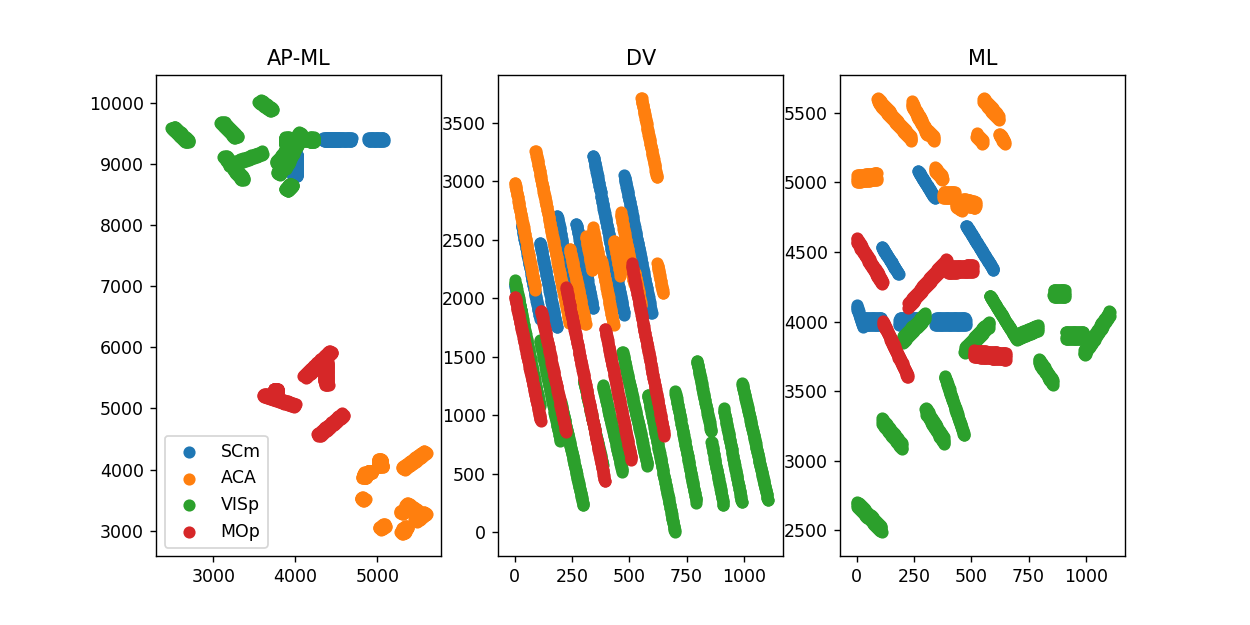

C:\Users\Le\Anaconda3b\lib\site-packages\ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app
C:\Users\Le\Anaconda3b\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\Le\Anaconda3b\lib\site-packages\ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reu

In [4]:
sublocs = master_locs[master_locs.allen_ontology == 'SCm']
plt.figure(figsize=(10, 5))
plt.subplot(131)
plt.scatter(sublocs.ccf_lr, sublocs.ccf_ap, label='SCm')
plt.title('AP-ML')
plt.subplot(132)
plt.scatter(np.arange(len(sublocs.ccf_dv)), sublocs.ccf_dv)
plt.title('DV')
plt.subplot(133)
plt.scatter(np.arange(len(sublocs.ccf_dv)), sublocs.ccf_lr)
plt.title('ML')

sublocs = master_locs[master_locs.allen_ontology == 'ACA']
#plt.figure()
plt.subplot(131)
plt.scatter(sublocs.ccf_lr, sublocs.ccf_ap, label='ACA')
plt.subplot(132)
plt.scatter(np.arange(len(sublocs.ccf_dv)), sublocs.ccf_dv)
plt.subplot(133)
plt.scatter(np.arange(len(sublocs.ccf_dv)), sublocs.ccf_lr)

sublocs = master_locs[master_locs.allen_ontology == 'VISp']
#plt.figure()
plt.subplot(131)
plt.scatter(sublocs.ccf_lr, sublocs.ccf_ap, label='VISp')
plt.subplot(132)
plt.scatter(np.arange(len(sublocs.ccf_dv)), sublocs.ccf_dv)
plt.subplot(133)
plt.scatter(np.arange(len(sublocs.ccf_dv)), sublocs.ccf_lr)

sublocs = master_locs[master_locs.allen_ontology == 'MOp']
#plt.figure()
plt.subplot(131)
plt.scatter(sublocs.ccf_lr, sublocs.ccf_ap, label='MOp')
plt.legend()

plt.subplot(132)
plt.scatter(np.arange(len(sublocs.ccf_dv)), sublocs.ccf_dv)
plt.subplot(133)
plt.scatter(np.arange(len(sublocs.ccf_dv)), sublocs.ccf_lr)



<IPython.core.display.Javascript object>


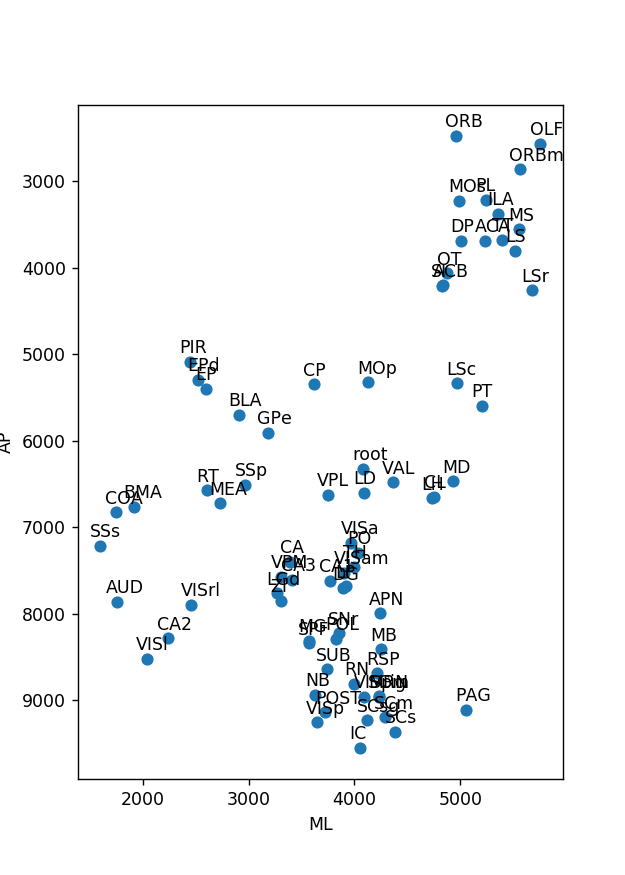

Text(0, 0.5, 'AP')

In [5]:
# Total number of units
area_mean = master_locs.groupby('allen_ontology')['ccf_ap', 'ccf_lr', 'ccf_dv'].mean().reset_index()
area_std = master_locs.groupby('allen_ontology')['ccf_ap', 'ccf_lr', 'ccf_dv'].std().reset_index()

plt.figure(figsize=(5, 7))
plt.scatter(area_mean.ccf_lr, area_mean.ccf_ap)
for i in range(area_mean.shape[0]):
    #print(i)
    plt.text(area_mean.ccf_lr[i] - 100, area_mean.ccf_ap[i] - 100, area_mean.allen_ontology[i], fontsize=10)
#plt.show()
plt.gca().invert_yaxis()
plt.xlabel('ML')
plt.ylabel('AP')

### Decision times

Here we calculate decision times based on wheel activity. This is done for all sessions.

In [18]:
def find_closest_choice_pts(tstim, choicepts):
    candidates = choicepts[choicepts > tstim - 0.1]
    return min(candidates)

def find_decision_times(stim_times, choice_points, choice_lst):
    closestChoicePt = []
    for idx, time in enumerate(stim_times):
        if choice_lst[idx] == 0:
            closest = np.nan
        else:
            closest = find_closest_choice_pts(time, choice_points)
        closestChoicePt.append(closest)
        #print('Trial: ', idx, ', stim on at ', time, ', closest: ', closest)
    return closestChoicePt

In [26]:
for session in all_sess:
    #directory = 'Radnitz_2017-01-09'
    _,directory,_ = session.split('\\')
    print(directory)
    trials_stim_times = np.load(os.path.join('Data', directory, 'trials.visualStim_times.npy'))[:,0]
    trials_choice = np.load(os.path.join('Data', directory, 'trials.response_choice.npy'))[:,0]
    
    trials_wheel = np.load(os.path.join('Data', directory, 'wheel.position.npy'))[:,0]
    wheel_tstamps = np.load(os.path.join('Data', directory, 'wheel.timestamps.npy'))
    wheelMoveType = np.load(os.path.join('Data', directory, 'wheelMoves.type.npy'))[:,0]
    wheelMoveIntervals = np.load(os.path.join('Data', directory, 'wheelMoves.intervals.npy'))
    tstampsInterp = np.linspace(wheel_tstamps[0,1], wheel_tstamps[1,1], len(trials_wheel))
    choicePoints = wheelMoveIntervals[(wheelMoveType == 1) | (wheelMoveType == 2), 0]
    closestChoicePt = []
    decision_times = find_decision_times(trials_stim_times, choicePoints, trials_choice)
    np.save(os.path.join('Data', directory, 'trials.decision_times.npy'), decision_times)

Cori_2016-12-14
Cori_2016-12-17
Cori_2016-12-18
Forssmann_2017-11-01
Forssmann_2017-11-02
Forssmann_2017-11-04
Forssmann_2017-11-05
Hench_2017-06-15
Hench_2017-06-16
Hench_2017-06-17
Hench_2017-06-18
Lederberg_2017-12-05
Lederberg_2017-12-06
Lederberg_2017-12-07
Lederberg_2017-12-08
Lederberg_2017-12-09
Lederberg_2017-12-10
Lederberg_2017-12-11
Moniz_2017-05-15
Moniz_2017-05-16
Moniz_2017-05-18
Muller_2017-01-07
Muller_2017-01-08
Muller_2017-01-09
Radnitz_2017-01-08
Radnitz_2017-01-09
Radnitz_2017-01-10
Radnitz_2017-01-11
Radnitz_2017-01-12
Richards_2017-10-29
Richards_2017-10-30
Richards_2017-10-31
Richards_2017-11-01
Richards_2017-11-02
Tatum_2017-12-06
Tatum_2017-12-07
Tatum_2017-12-08
Tatum_2017-12-09
Theiler_2017-10-11


### Recording locations

In [6]:
merged_tbls = []
for session in all_sess:
    _,directory,_ = session.split('\\')

    # Location information
    locations = pd.read_csv(os.path.join('Data', directory, 'channels.brainLocation.tsv'), sep='\t')
    locations['locIdx'] = locations.index - locations.index[0] + 1
    assert(min(locations['locIdx']) == 1)

    # Cluster information
    clusters_annotation = np.load(os.path.join('Data', directory, 'clusters._phy_annotation.npy'))[:,0]
    clusters_peakChannel = np.load(os.path.join('Data', directory, 'clusters.peakChannel.npy'))[:,0]
    clusters_brainLoc = locations.allen_ontology[clusters_peakChannel]
    clusters_fr = pd.DataFrame({'annotation': clusters_annotation, 'peakChannel': clusters_peakChannel,
                               'clusterIdx': np.arange(len(clusters_peakChannel))})
    
    # Merge
    merged_tbl = pd.merge(clusters_fr, locations, right_on='locIdx', left_on='peakChannel')
    merged_tbl['directory'] = directory
    
    merged_tbls.append(merged_tbl)
    #print(clusters_peakChannel.max(), clusters_peakChannel.min(), locations.shape[0])


In [7]:
# Count the number of units in each area
master_merged_tbls = pd.concat(merged_tbls)
area_count = master_merged_tbls[master_merged_tbls.annotation >= 2].groupby('allen_ontology')['ccf_ap'].count()
pd.DataFrame(area_count).head(40)

,ccf_ap
allen_ontology,
ACA,841
ACB,337
APN,247
AUD,246
BLA,317
BMA,104
CA,193
CA1,1360
CA2,115


In [8]:
master_merged_tbls[(master_merged_tbls.annotation >= 2) & (master_merged_tbls.directory == 'Cori_2016-12-14') & 
                  (master_merged_tbls.allen_ontology == 'ACA')]

,annotation,peakChannel,clusterIdx,ccf_ap,ccf_dv,ccf_lr,allen_ontology,locIdx,directory
0,3.0,224.0,0,4090.0,2445.4,5012.4,ACA,224,Cori_2016-12-14
1,3.0,224.0,133,4090.0,2445.4,5012.4,ACA,224,Cori_2016-12-14
4,3.0,172.0,2,4172.1,2979.3,5018.3,ACA,172,Cori_2016-12-14
13,3.0,250.0,350,4053.4,2188.3,5033.0,ACA,250,Cori_2016-12-14
19,3.0,241.0,7,4069.2,2267.4,5063.3,ACA,241,Cori_2016-12-14
73,3.0,225.0,23,4092.9,2425.6,5060.4,ACA,225,Cori_2016-12-14
75,3.0,225.0,141,4092.9,2425.6,5060.4,ACA,225,Cori_2016-12-14
76,3.0,225.0,146,4092.9,2425.6,5060.4,ACA,225,Cori_2016-12-14
80,3.0,256.0,26,4042.5,2129.0,5018.2,ACA,256,Cori_2016-12-14
83,3.0,256.0,205,4042.5,2129.0,5018.2,ACA,256,Cori_2016-12-14


### Save good units and their areas

In [9]:
pd.DataFrame.to_csv(master_merged_tbls, 'labeled_clusters_all_session.csv')

### Load classified result
We now load the results as processed by the GLM

In [206]:
glmdata = scipy.io.loadmat('compiled_allGLMResults.mat')

In [207]:
glmdata

{'__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Thu Apr 23 10:17:16 2020',
 '__version__': '1.0',
 'area': array([[array(['ACA'], dtype='<U3'), array(['VISp'], dtype='<U4'),
         array(['VISp'], dtype='<U4'), ..., array(['VISam'], dtype='<U5'),
         array(['VISam'], dtype='<U5'), array(['VISam'], dtype='<U5')]],
       dtype=object),
 'clusterID': array([[   0, 1001, 1002, ...,  991,  994,  997]], dtype=uint16),
 'directory': array([[array(['Cori_2016-12-14'], dtype='<U15'),
         array(['Cori_2016-12-14'], dtype='<U15'),
         array(['Cori_2016-12-14'], dtype='<U15'), ...,
         array(['Theiler_2017-10-11'], dtype='<U18'),
         array(['Theiler_2017-10-11'], dtype='<U18'),
         array(['Theiler_2017-10-11'], dtype='<U18')]], dtype=object),
 'sigCellsLeft': array([[0, 1, 0, ..., 0, 0, 0]], dtype=uint8),
 'sigCellsPun': array([[0, 1, 0, ..., 0, 0, 0]], dtype=uint8),
 'sigCellsRew': array([[0, 1, 1, ..., 0, 0, 0]], dtype=uin

In [208]:
dataArea = np.array(glmdata['area'])[0]
dataClusterID = glmdata['clusterID'][0]
dataDir = glmdata['directory'][0]
sigLeft = glmdata['sigCellsLeft'][0]
sigRight = glmdata['sigCellsRight'][0]
sigPun = glmdata['sigCellsPun'][0]
sigRew = glmdata['sigCellsRew'][0]
sigStim = glmdata['sigCellsStim'][0]


area = []
directory = []
for elem in dataArea:
    area.append(elem[0])

for elem in dataDir:
    directory.append(elem[0])



In [211]:
glmtbl = pd.DataFrame({'area': area, 'directory': directory, 'clusterID': dataClusterID,
                      'left': sigLeft, 'right': sigRight, 'reward': sigRew, 'punish': sigPun, 'stimulus': sigStim})

In [212]:
glmMerge.area.unique()

array(['ACA', 'VISp', 'VISpm', 'VISam', 'SCm'], dtype=object)

In [155]:
# Merge with master
glmMerge = pd.merge(master_merged_tbls, glmtbl, left_on=['directory', 'clusterIdx'],
                   right_on=['directory', 'clusterID'], how='right')
glmMerge.head()

,annotation,peakChannel,clusterIdx,ccf_ap,ccf_dv,ccf_lr,allen_ontology,locIdx,directory,area,clusterID,left,right,reward,punish,stimulus
0,3.0,224.0,0,4090.0,2445.4,5012.4,ACA,224,Cori_2016-12-14,ACA,0,0,0,0,0,0
1,3.0,224.0,133,4090.0,2445.4,5012.4,ACA,224,Cori_2016-12-14,ACA,133,0,0,0,0,0
2,3.0,172.0,2,4172.1,2979.3,5018.3,ACA,172,Cori_2016-12-14,ACA,2,0,0,1,0,0
3,3.0,250.0,350,4053.4,2188.3,5033.0,ACA,250,Cori_2016-12-14,ACA,350,0,0,0,0,0
4,3.0,241.0,7,4069.2,2267.4,5063.3,ACA,241,Cori_2016-12-14,ACA,7,0,0,0,0,0


In [172]:
glmACAstimulus = glmMerge[(glmMerge.area == 'ACA') & (glmMerge.stimulus)]
glmACAreward = glmMerge[(glmMerge.area == 'ACA') & (glmMerge.reward)]
glmVISpreward = glmMerge[((glmMerge.area == 'VISp') | (glmMerge.area == 'VISam') | (glmMerge.area == 'VISpm')) & (glmMerge.reward)]
glmVISpstimulus = glmMerge[((glmMerge.area == 'VISp') | (glmMerge.area == 'VISam') | (glmMerge.area == 'VISpum')) & (glmMerge.stimulus)]

<IPython.core.display.Javascript object>


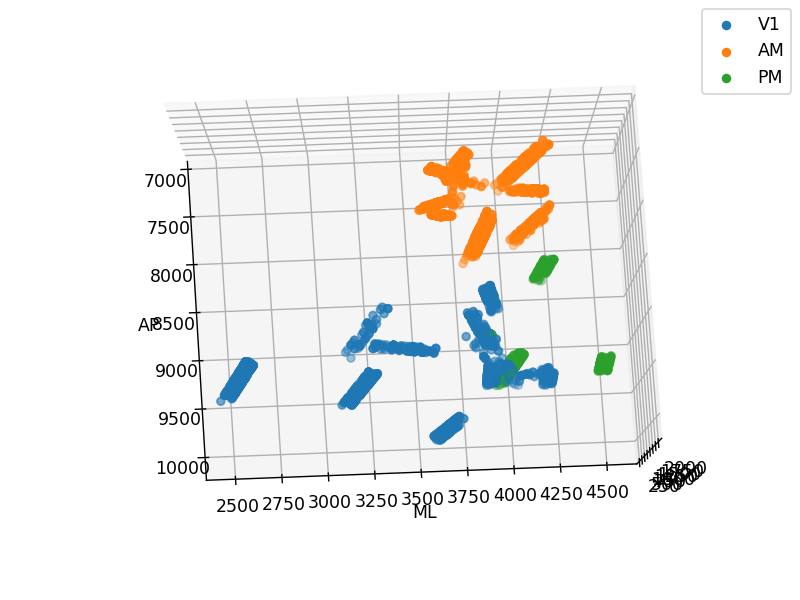

In [196]:
# Where are VISp, VISam and VISpm?
glmVISp = glmMerge[glmMerge.area == 'VISp']
glmVISam = glmMerge[glmMerge.area == 'VISam']
glmVISpm = glmMerge[glmMerge.area == 'VISpm']
glmACA = glmMerge[glmMerge.area == 'ACA']

fig = plt.figure()
ax = Axes3D(fig)
#ax.scatter(glmACAstimulus.ccf_ap, glmACAstimulus.ccf_lr, glmACAstimulus.ccf_dv, alpha=0.5)
#ax.scatter(glmACAreward.ccf_ap, glmACAreward.ccf_lr, glmACAreward.ccf_dv, alpha=0.5)

ax.scatter(glmVISp.ccf_ap, glmVISp.ccf_lr, glmVISp.ccf_dv, label='V1')
ax.scatter(glmVISam.ccf_ap, glmVISam.ccf_lr, glmVISam.ccf_dv, label='AM')
ax.scatter(glmVISpm.ccf_ap, glmVISpm.ccf_lr, glmVISpm.ccf_dv, label='PM')

plt.xlabel('AP')
plt.ylabel('ML')
plt.legend()


In [188]:
def get_filtered_counts(areaFrame):
    stimFrame = areaFrame[areaFrame.stimulus == 1]
    rewFrame = areaFrame[areaFrame.reward == 1]
    countsStim, xbins, ybins = np.histogram2d(stimFrame.ccf_lr, stimFrame.ccf_ap, bins=40)
    countsRew, xbins, ybins = np.histogram2d(rewFrame.ccf_lr, rewFrame.ccf_ap, bins=40)
    filteredStim = scipy.ndimage.gaussian_filter(countsStim, sigma=2)
    filteredRew = scipy.ndimage.gaussian_filter(countsRew, sigma=2)
    filteredDiff = scipy.ndimage.gaussian_filter(countsStim - countsRew, sigma=2)
    return filteredStim, filteredRew, filteredDiff, xbins, ybins

<IPython.core.display.Javascript object>


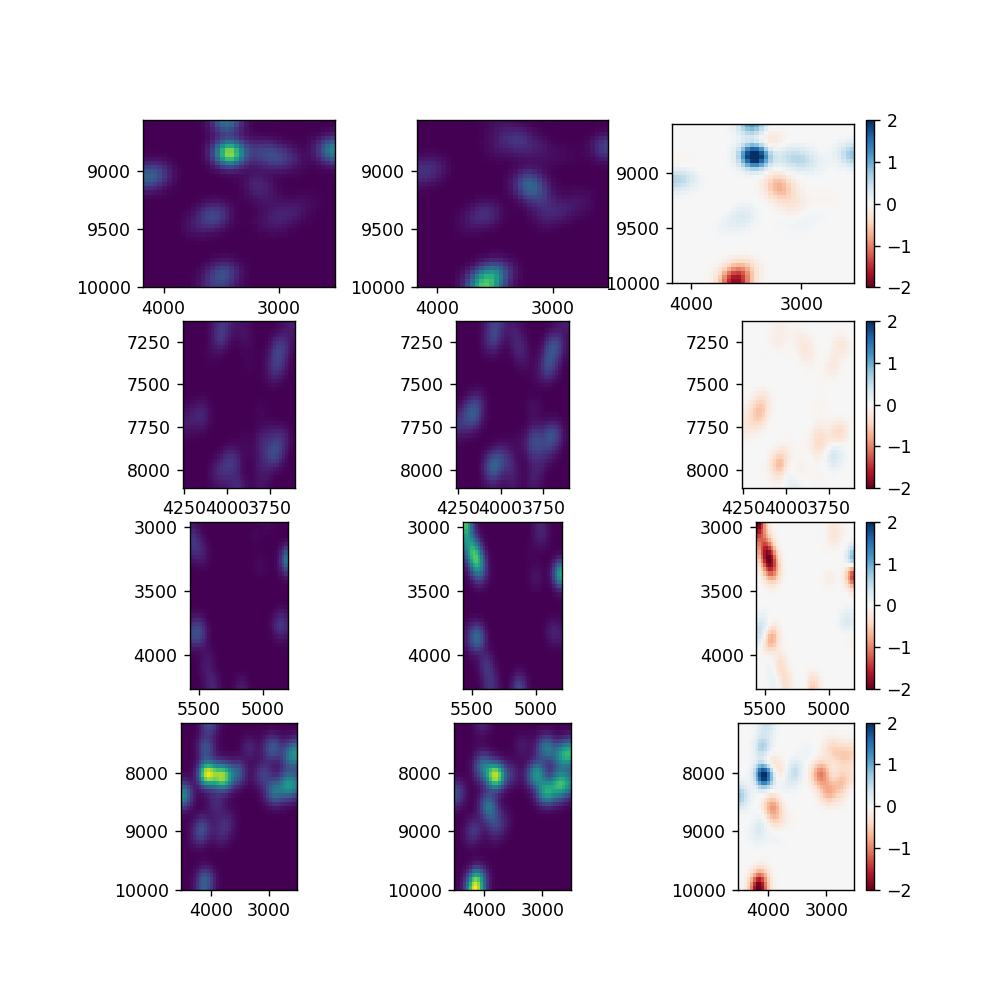

In [198]:
countV1Stim, countV1Rew, countV1Diff, xbinsV1, ybinsV1 = get_filtered_counts(glmVISp)
countACAStim, countACARew, countACADiff, xbinsACA, ybinsACA = get_filtered_counts(glmACA)
countAMStim, countAMRew, countAMDiff, xbinsAM, ybinsAM = get_filtered_counts(glmVISam)
countPMStim, countPMRew, countPMDiff, xbinsPM, ybinsPM = get_filtered_counts(glmVISpm)
countVISStim, countVISRew, countVISDiff, xbinsVIS, ybinsVIS = get_filtered_counts(pd.concat([glmVISp, glmVISam, glmVISpm]))

# V1
plt.figure(figsize=(8,8))
plt.subplot(431)
plt.imshow(countV1Stim, vmin=0, vmax=3, extent=[xbinsV1[0], xbinsV1[-1], ybinsV1[0], ybinsV1[-1]])
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()

plt.subplot(432)
plt.imshow(countV1Rew, vmin=0, vmax=3, extent=[xbinsV1[0], xbinsV1[-1], ybinsV1[0], ybinsV1[-1]])
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()

plt.subplot(433)
plt.imshow(countV1Diff, cmap='RdBu', vmin=-2, vmax=2, extent=[xbinsV1[0], xbinsV1[-1], ybinsV1[0], ybinsV1[-1]])
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.colorbar()

# AM
plt.subplot(434)
plt.imshow(countAMStim, vmin=0, vmax=3, extent=[xbinsAM[0], xbinsAM[-1], ybinsAM[0], ybinsAM[-1]])
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()

plt.subplot(435)
plt.imshow(countAMRew, vmin=0, vmax=3, extent=[xbinsAM[0], xbinsAM[-1], ybinsAM[0], ybinsAM[-1]])
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()

plt.subplot(436)
plt.imshow(countAMDiff, cmap='RdBu', vmin=-2, vmax=2, extent=[xbinsAM[0], xbinsAM[-1], ybinsAM[0], ybinsAM[-1]])
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.colorbar()

# PM
plt.subplot(437)
plt.imshow(countACAStim, vmin=0, vmax=3, extent=[xbinsACA[0], xbinsACA[-1], ybinsACA[0], ybinsACA[-1]])
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()

plt.subplot(438)
plt.imshow(countACARew, vmin=0, vmax=3, extent=[xbinsACA[0], xbinsACA[-1], ybinsACA[0], ybinsACA[-1]])
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()


plt.subplot(439)
plt.imshow(countACADiff, cmap='RdBu', vmin=-2, vmax=2, extent=[xbinsACA[0], xbinsACA[-1], ybinsACA[0], ybinsACA[-1]])
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.colorbar()

# Combined
plt.subplot(4,3,10)
plt.imshow(countVISStim, vmin=0, vmax=3, extent=[xbinsVIS[0], xbinsVIS[-1], ybinsVIS[0], ybinsVIS[-1]])
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()

plt.subplot(4,3,11)
plt.imshow(countVISRew, vmin=0, vmax=3, extent=[xbinsVIS[0], xbinsVIS[-1], ybinsVIS[0], ybinsVIS[-1]])
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()


plt.subplot(4,3,12)
plt.imshow(countVISDiff, cmap='RdBu', vmin=-2, vmax=2, extent=[xbinsVIS[0], xbinsVIS[-1], ybinsVIS[0], ybinsVIS[-1]])
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.colorbar()

<IPython.core.display.Javascript object>


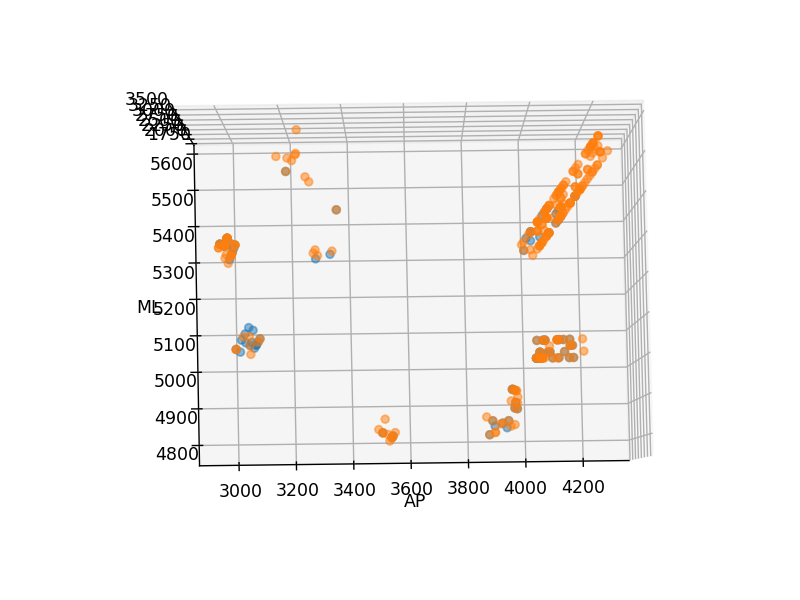

Text(0.5, 0, 'ML')

In [110]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(glmACAstimulus.ccf_ap, glmACAstimulus.ccf_lr, glmACAstimulus.ccf_dv, alpha=0.5)
ax.scatter(glmACAreward.ccf_ap, glmACAreward.ccf_lr, glmACAreward.ccf_dv, alpha=0.5)

#ax.scatter(glmVISpstimulus.ccf_ap, glmVISpstimulus.ccf_lr, glmVISpstimulus.ccf_dv)
#ax.scatter(glmVISpreward.ccf_ap, glmVISpreward.ccf_lr, glmVISpreward.ccf_dv)

plt.xlabel('AP')
plt.ylabel('ML')

<IPython.core.display.Javascript object>


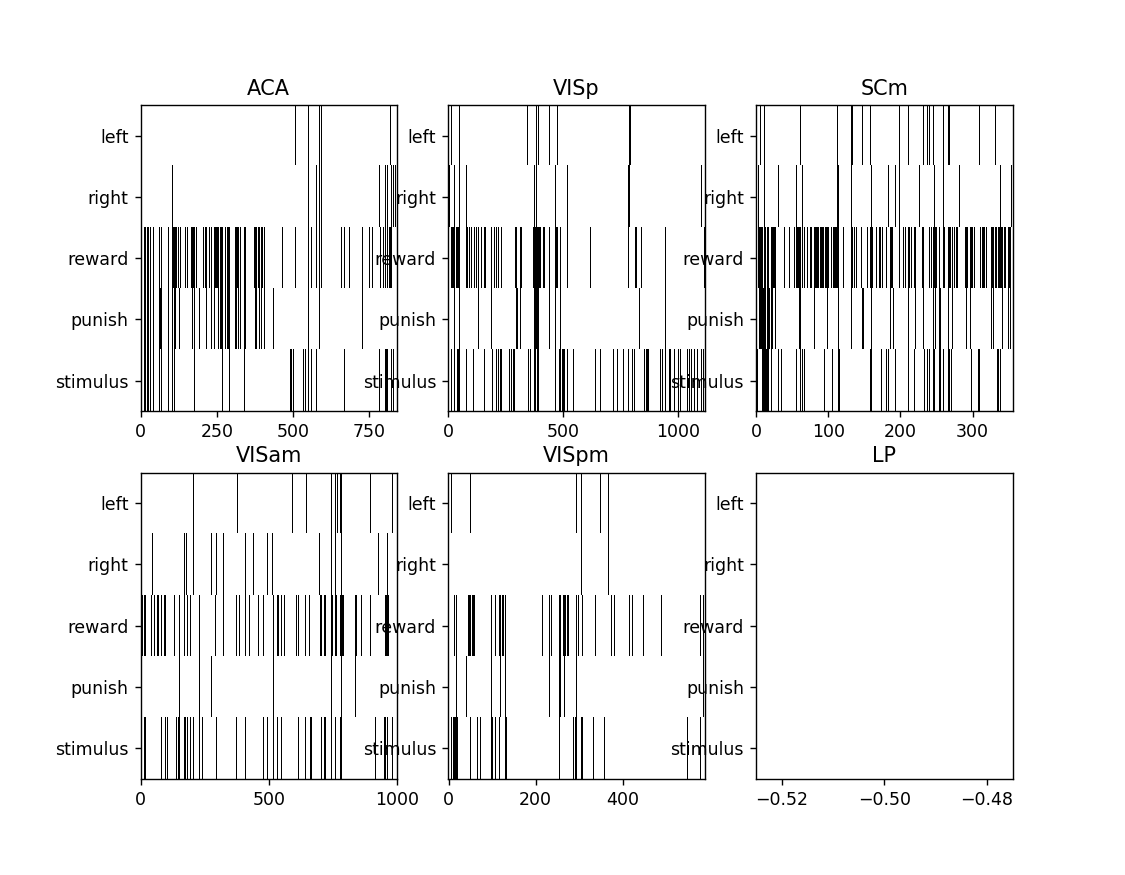

C:\Users\Le\Anaconda3b\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.
  after removing the cwd from sys.path.


In [199]:
def plot_area_units(area, tbl):
    subtbl = tbl[tbl.area == area]
    arr = np.array(subtbl[['left', 'right', 'reward', 'punish', 'stimulus']])
    plt.imshow(arr.T, aspect='auto',cmap='gray_r')
    plt.yticks(np.arange(5), ['left', 'right', 'reward', 'punish', 'stimulus'])
    plt.title(area)

plt.figure(figsize=(9,7))
plt.subplot(231)
plot_area_units('ACA', glmMerge)
plt.subplot(232)
plot_area_units('VISp', glmMerge)
plt.subplot(233)
plot_area_units('SCm', glmMerge)
plt.subplot(234)
plot_area_units('VISam', glmMerge)
plt.subplot(235)
plot_area_units('VISpm', glmMerge)
plt.subplot(236)
plot_area_units('LP', glmMerge)
#plt.subplot(236)
#plot_area_units('VISrl', glmMerge)
